In [6]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from IPython.display import Audio
from scikitplot.metrics import plot_confusion_matrix, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

warnings.filterwarnings('ignore')

### Load Data (taken form marcus's code)

In [7]:
paths = []
labels = []

# Use os.walk to walk through the directory structure
for dirname, _, filenames in os.walk(r'data'):
    for filename in filenames:
        if filename == '.DS_Store':
            continue  # Skip this file
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        paths.append(full_path)
        
        # Extract label and gender from the directory name
        # Assumes the structure is data/label_gender/filename
        folder_name = os.path.basename(dirname)
        label = folder_name
        emotion = label.split('_')[0]
        labels.append(emotion.lower())

# Create a DataFrame with the collected data
df = pd.DataFrame({
    'file_path': paths,
    'label': labels,
})

# Display the first few rows of the DataFrame to verify
df.head()

,file_path,label
0,data\Angry_Female\anger_xn_1.wav,angry
1,data\Angry_Female\anger_xn_10.wav,angry
2,data\Angry_Female\anger_xn_11.wav,angry
3,data\Angry_Female\anger_xn_12.wav,angry
4,data\Angry_Female\anger_xn_13.wav,angry


### Feature Engineering

In [8]:
def extract_feature(file_path, **kwargs):
    """
    Extract features from audio file `file_path`
        Features:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    try:
        X, sample_rate = librosa.load(file_path, duration=3, offset=0.5)
        result = np.array([])   # values for all features stored in a single array
        result_dict = {}    # values of each feature
        if chroma or contrast:
            stft = np.abs(librosa.stft(X))
        if mfcc:
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result = np.hstack((result, mfccs))
            result_dict['mfcc'] = mfccs
        if chroma:
            chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, chroma))
            result_dict['chroma'] = chroma
        if mel:
            mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
            result = np.hstack((result, mel))
            result_dict['mel'] = mel
        if contrast:
            contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
            result = np.hstack((result, contrast))
            result_dict['contrast'] = contrast
        if tonnetz:
            tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
            result = np.hstack((result, tonnetz))
            result_dict['tonnetz'] = tonnetz
        return result, result_dict
    except Exception as e:
        print(e)

extracted_features = {
    "mfcc": True,
    "chroma": True,
    "mel": True,
    "contrast": True,
    "tonnetz": True
}

res, res_dict = extract_feature('data/Angry_Female/ws_anger_01.wav', **extracted_features)

### Split in train, validation and test sets

In [9]:
X = df['file_path']
y = df['label']

# Separate into (train, val) and test sets
train_val_X, test_X, train_val_y, test_y = train_test_split(X, y, test_size=0.1, random_state=4242)

# Further split the (train, val) set into separate training and validation sets
train_X, val_X, train_y, val_y = train_test_split(train_val_X, train_val_y, test_size=0.2, random_state=4242)
train_X

503        data\Sad_Female\jt_sadness_13.wav
651             data\Sad_Male\sad_xnm_38.wav
172       data\Happy_Female\happy_xnj_30.wav
337        data\Happy_Male\ml_happy_B-29.wav
369    data\Neutral_Female\neutral_xn_10.wav
                       ...                  
155       data\Angry_Male\ml_angerery-22.wav
42         data\Angry_Female\jt_anger_10.wav
148       data\Angry_Male\ml_angerery-15.wav
327        data\Happy_Male\ml_happy_B-19.wav
407    data\Neutral_Female\ws_neutral_18.wav
Name: file_path, Length: 471, dtype: object

In [10]:
# Extract features for all files in training data
def extract_features_from_df(df, **kwargs):
    features = []
    for path in df:
        feature, feature_dict = extract_feature(path, **kwargs)
        features.append(feature)
    return features

train_X_features = extract_features_from_df(train_X, **extracted_features)    

In [11]:
print(f'length: {len(train_X_features)}')
print(f'feature shape: {train_X_features[0].shape}')

length: 471
feature shape: (193,)


### Model Training

In [12]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred, average='weighted')
    recall = recall_score(y_true=y_true, y_pred=y_pred, average='weighted')
    f1 = f1_score(y_true=y_true, y_pred=y_pred, average='weighted')
    return accuracy, precision, recall, f1

#### SVM

In [27]:
# Train SVM
model_svm = SVC(probability=True, random_state=4242, verbose=True)
model_svm.fit(train_X_features, train_y)

# Hyperparameter tuning / Cross Validation maybe

# Predit on validation set
val_X_features = extract_features_from_df(val_X, **extracted_features)
pred_val_y = model_svm.predict(val_X_features)

# Evaluate metrics
svm_accuracy, svm_precision, svm_recall, svm_f1 = calculate_metrics(val_y, pred_val_y)

results_df = pd.DataFrame({
    'Model': ['SVM'],
    'Accuracy': [svm_accuracy],
    'Precision': [svm_precision],
    'Recall': [svm_recall],
    'F1': [svm_f1]
})
results_df

[LibSVM]

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038


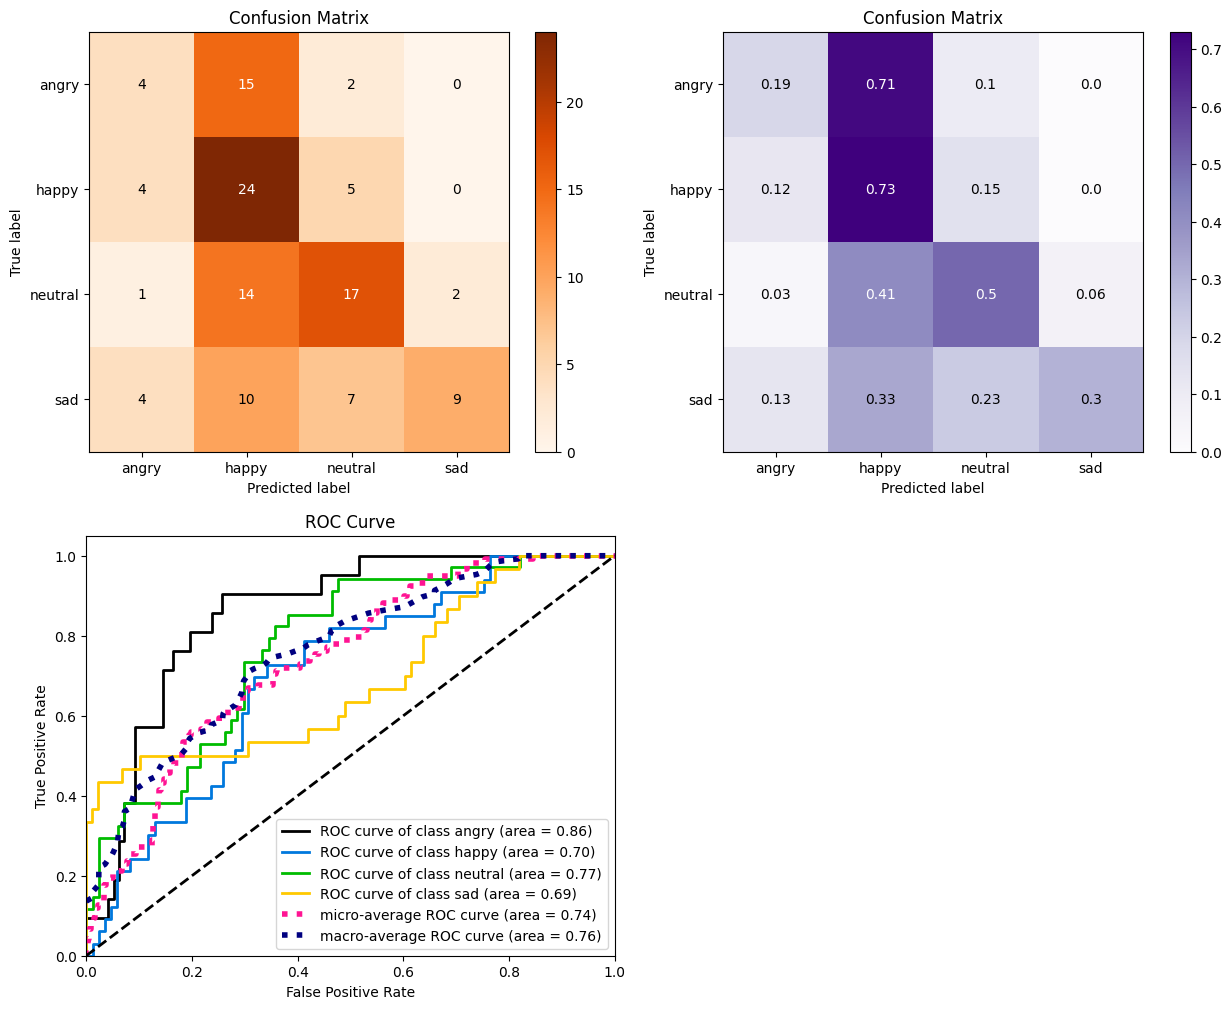

In [28]:
def plot_visualisations(y_true, y_pred, y_pred_probs):
    fig = plt.figure(figsize=(15,12))

    ax1 = fig.add_subplot(221)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred,
                            title="Confusion Matrix",
                            cmap="Oranges",
                            ax=ax1)

    ax2 = fig.add_subplot(222)
    plot_confusion_matrix(y_true=y_true, y_pred=y_pred,
                            normalize=True,
                            title="Confusion Matrix",
                            cmap="Purples",
                            ax=ax2)
    
    ax3 = fig.add_subplot(223)
    plot_roc_curve(y_true, y_pred_probs,
                    title="ROC Curve",
                    ax=ax3)

    plt.show()

pred_val_y_probs = model_svm.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### Random Forest

In [29]:
# Train RandomForestClassifier
model_rfc = RandomForestClassifier(max_depth=50, random_state=4242, verbose=1)
model_rfc.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_rfc.predict(val_X_features)

# Evaluate metrics
# Evaluate metrics
rfc_accuracy, rfc_precision, rfc_recall, rfc_f1 = calculate_metrics(val_y, pred_val_y)

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier'],
    'Accuracy': [svm_accuracy, rfc_accuracy],
    'Precision': [svm_precision, rfc_precision],
    'Recall': [svm_recall, rfc_recall],
    'F1': [svm_f1, rfc_f1]
})
results_df

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


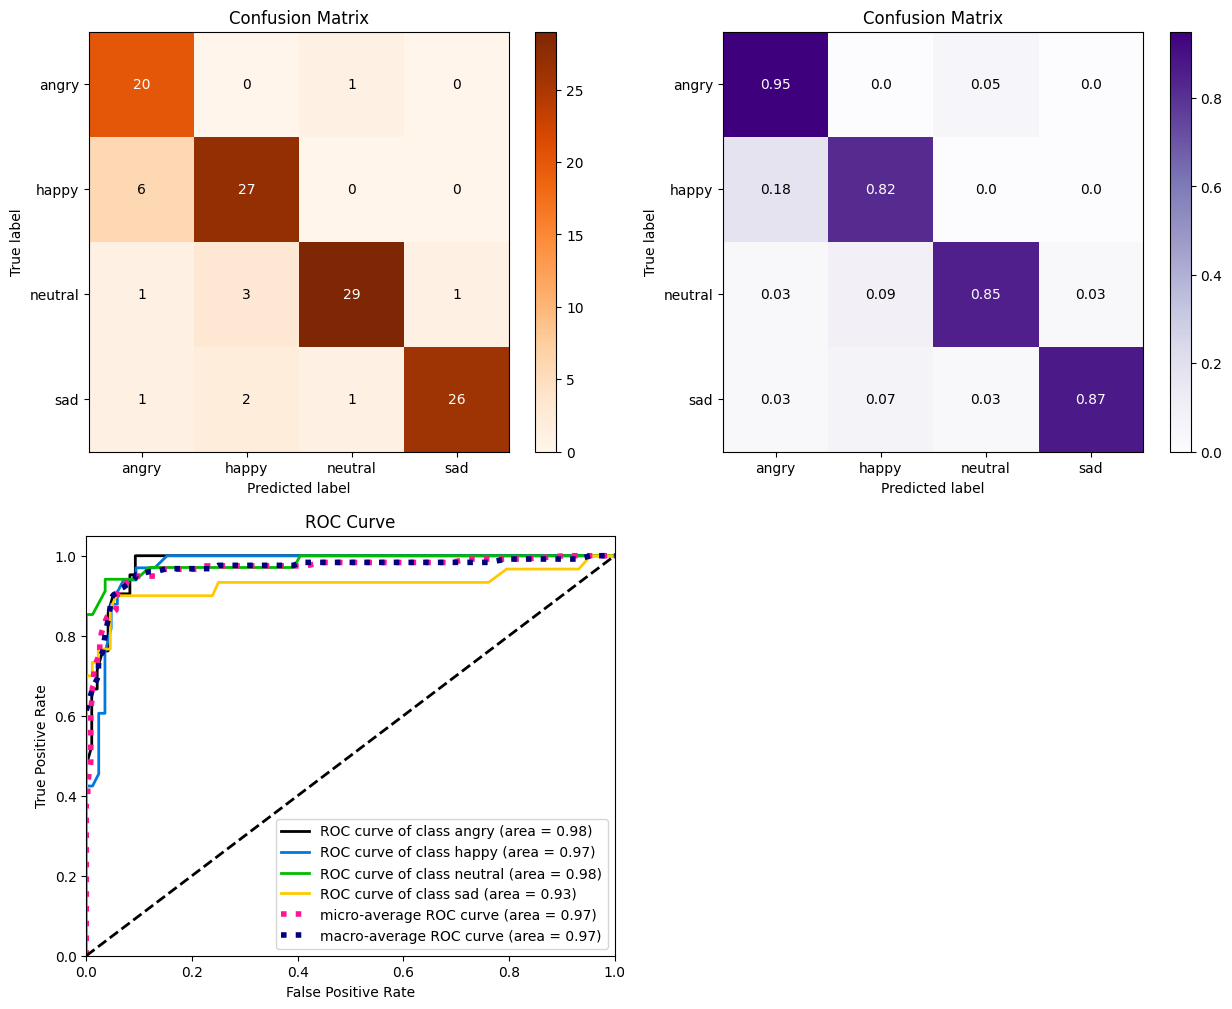

In [30]:
pred_val_y_probs = model_rfc.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### NN

In [31]:
# Neural Network

# Set hyperparameters
hidden_layers = (300, 200, 100)
solver = 'adam'
# solver = 'lbfgs'
max_iter = 200
learning_rate = 'constant'
learning_rate_init = 0.001

# Train model
model_nn = MLPClassifier(hidden_layer_sizes=hidden_layers, 
                         random_state=4242, 
                         solver=solver, 
                         max_iter=max_iter, 
                         learning_rate=learning_rate, 
                         learning_rate_init=learning_rate_init,
                         early_stopping=True,
                         verbose=True
                    )
model_nn.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_nn.predict(val_X_features)

# Evaluate metrics
nn_accuracy, nn_precision, nn_recall, nn_f1 = calculate_metrics(val_y, pred_val_y)

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier', 'MLPClassifier'],
    'Accuracy': [svm_accuracy, rfc_accuracy, nn_accuracy],
    'Precision': [svm_precision, rfc_precision, nn_precision],
    'Recall': [svm_recall, rfc_recall, nn_recall],
    'F1': [svm_f1, rfc_f1, nn_f1]
})
results_df

Iteration 1, loss = 13.12154128
Validation score: 0.291667
Iteration 2, loss = 11.57489233
Validation score: 0.333333
Iteration 3, loss = 5.70546410
Validation score: 0.250000
Iteration 4, loss = 4.32247101
Validation score: 0.354167
Iteration 5, loss = 3.00997639
Validation score: 0.375000
Iteration 6, loss = 2.27899599
Validation score: 0.229167
Iteration 7, loss = 2.13079289
Validation score: 0.354167
Iteration 8, loss = 1.35209148
Validation score: 0.458333
Iteration 9, loss = 1.21460592
Validation score: 0.437500
Iteration 10, loss = 1.11476221
Validation score: 0.479167
Iteration 11, loss = 0.97658026
Validation score: 0.500000
Iteration 12, loss = 0.87855912
Validation score: 0.458333
Iteration 13, loss = 0.94639564
Validation score: 0.500000
Iteration 14, loss = 0.88270875
Validation score: 0.479167
Iteration 15, loss = 0.88676489
Validation score: 0.500000
Iteration 16, loss = 0.78369650
Validation score: 0.604167
Iteration 17, loss = 0.75758179
Validation score: 0.500000
Iter

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654
2,MLPClassifier,0.788136,0.789657,0.788136,0.787101


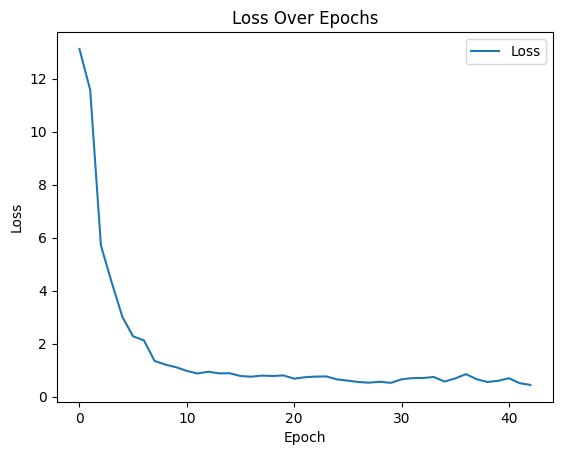

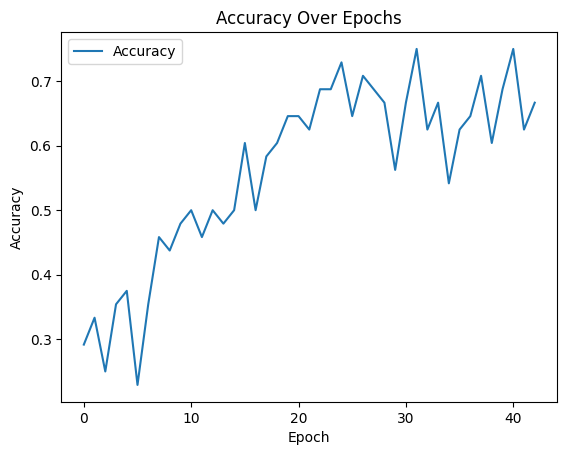

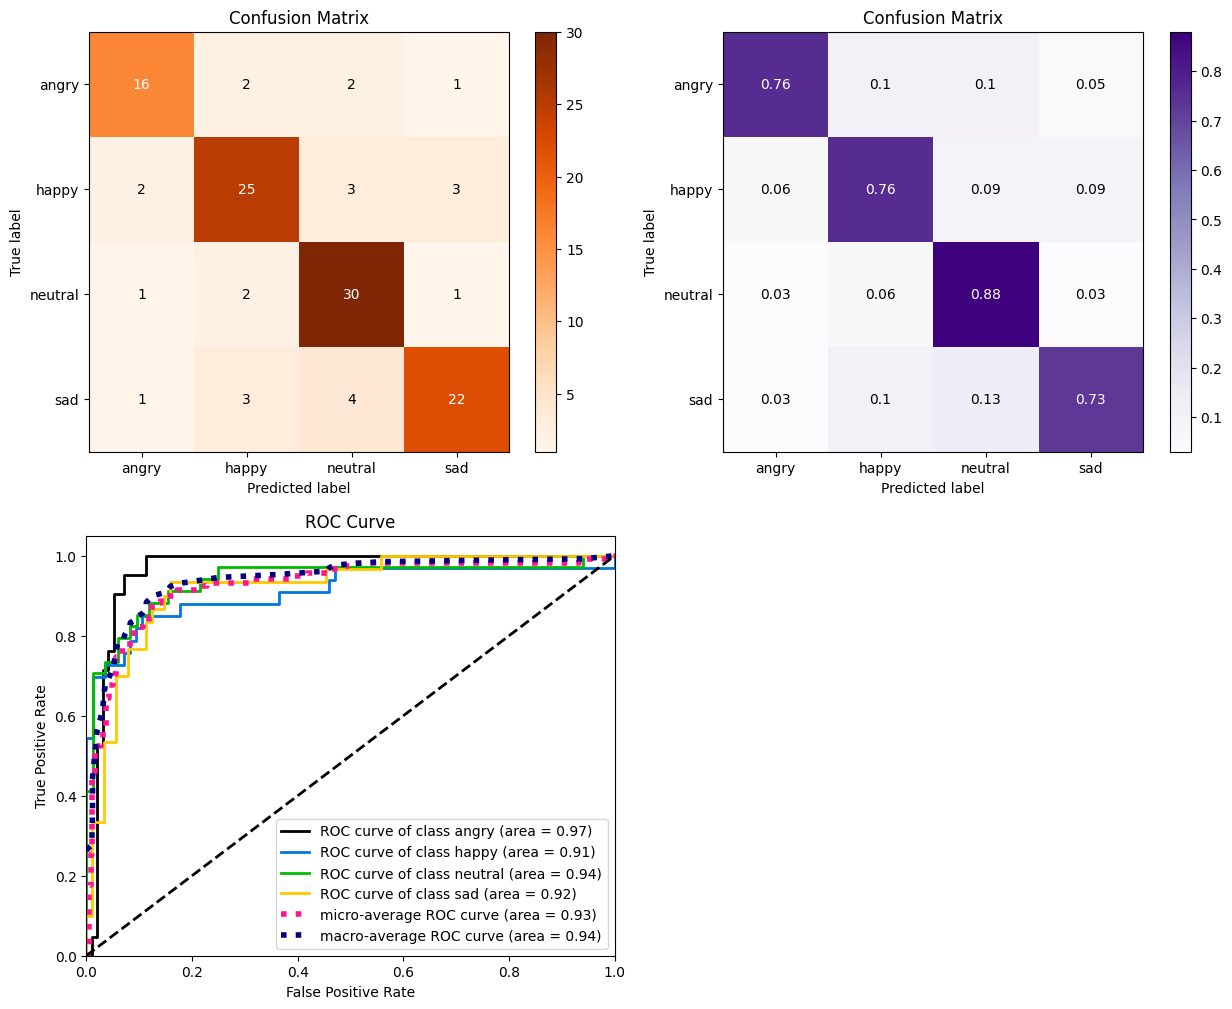

In [32]:
loss_curve = model_nn.loss_curve_
accuracy_curve = model_nn.validation_scores_

# Plot loss curve
plt.plot(loss_curve, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot accuracy curve
plt.plot(accuracy_curve, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

pred_val_y_probs = model_nn.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### k Nearest Neighbors

In [33]:
# k Nearest Neighbours

# Set hyperparameters
k = 4

# Train model
model_knn = KNeighborsClassifier(n_neighbors=k)
model_knn.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_knn.predict(val_X_features)

# Evaluate metrics
knn_accuracy, knn_precision, knn_recall, knn_f1 = calculate_metrics(val_y, pred_val_y)

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier', 'MLPClassifier', 'KNeighborsClassifier'],
    'Accuracy': [svm_accuracy, rfc_accuracy, nn_accuracy, knn_accuracy],
    'Precision': [svm_precision, rfc_precision, nn_precision, knn_precision],
    'Recall': [svm_recall, rfc_recall, nn_recall, knn_recall],
    'F1': [svm_f1, rfc_f1, nn_f1, knn_f1]
})
results_df

,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654
2,MLPClassifier,0.788136,0.789657,0.788136,0.787101
3,KNeighborsClassifier,0.838983,0.847747,0.838983,0.840065


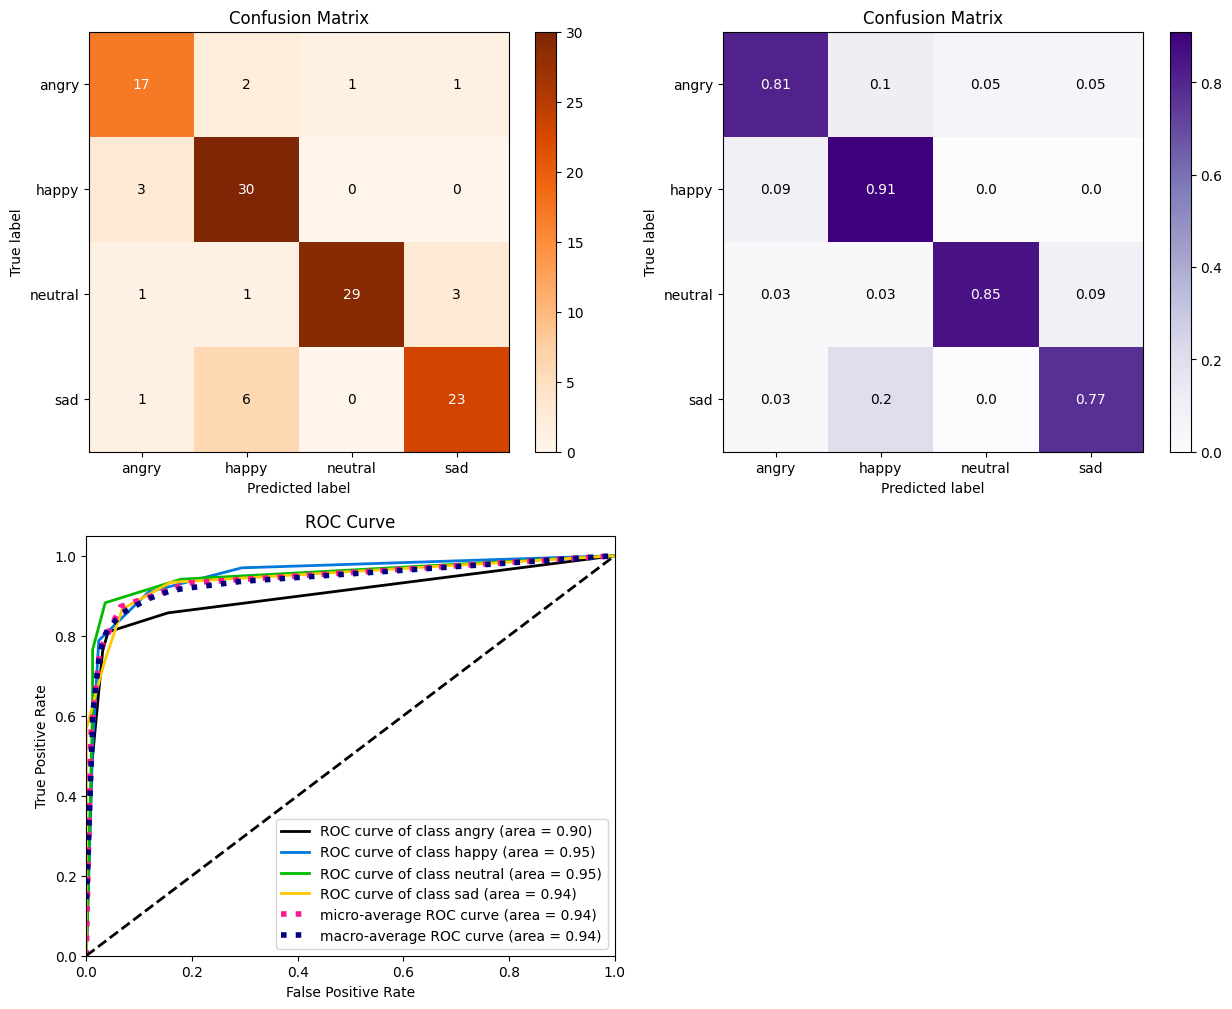

In [34]:
pred_val_y_probs = model_knn.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)

#### Gradient Boosting Classifier

In [35]:
# Set hyperparameters
learning_rate = 0.1
max_depth = 5


model_gbdt = GradientBoostingClassifier(max_depth=max_depth, learning_rate=learning_rate, random_state=4242, verbose=1)
model_gbdt.fit(train_X_features, train_y)

# Predict on validation set
pred_val_y = model_gbdt.predict(val_X_features)

# Evaluate metrics
gbdt_accuracy, gbdt_precision, gbdt_recall, gbdt_f1 = calculate_metrics(val_y, pred_val_y)

results_df = pd.DataFrame({
    'Model': ['SVM', 'RandomForestClassifier', 'MLPClassifier', 'KNeighborsClassifier', 'GradientBoosting'],
    'Accuracy': [svm_accuracy, rfc_accuracy, nn_accuracy, knn_accuracy, gbdt_accuracy],
    'Precision': [svm_precision, rfc_precision, nn_precision, knn_precision, gbdt_precision],
    'Recall': [svm_recall, rfc_recall, nn_recall, knn_recall, gbdt_recall],
    'F1': [svm_f1, rfc_f1, nn_f1, knn_f1, gbdt_f1]
})
results_df

      Iter       Train Loss   Remaining Time 
         1           1.1437           48.33s
         2           0.9664           46.96s
         3           0.8236           42.17s
         4           0.7103           41.01s
         5           0.6149           39.09s
         6           0.5379           38.54s
         7           0.4692           36.73s
         8           0.4144           35.27s
         9           0.3676           34.55s
        10           0.3243           34.46s
        20           0.1010           29.17s
        30           0.0342           25.01s
        40           0.0121           20.99s
        50           0.0046           17.42s
        60           0.0018           14.04s
        70           0.0007           10.48s
        80           0.0003            7.00s
        90           0.0001            3.53s
       100           0.0000            0.00s


,Model,Accuracy,Precision,Recall,F1
0,SVM,0.457627,0.527318,0.457627,0.444038
1,RandomForestClassifier,0.864407,0.877450,0.864407,0.866654
2,MLPClassifier,0.788136,0.789657,0.788136,0.787101
3,KNeighborsClassifier,0.838983,0.847747,0.838983,0.840065
4,GradientBoosting,0.855932,0.869129,0.855932,0.857285


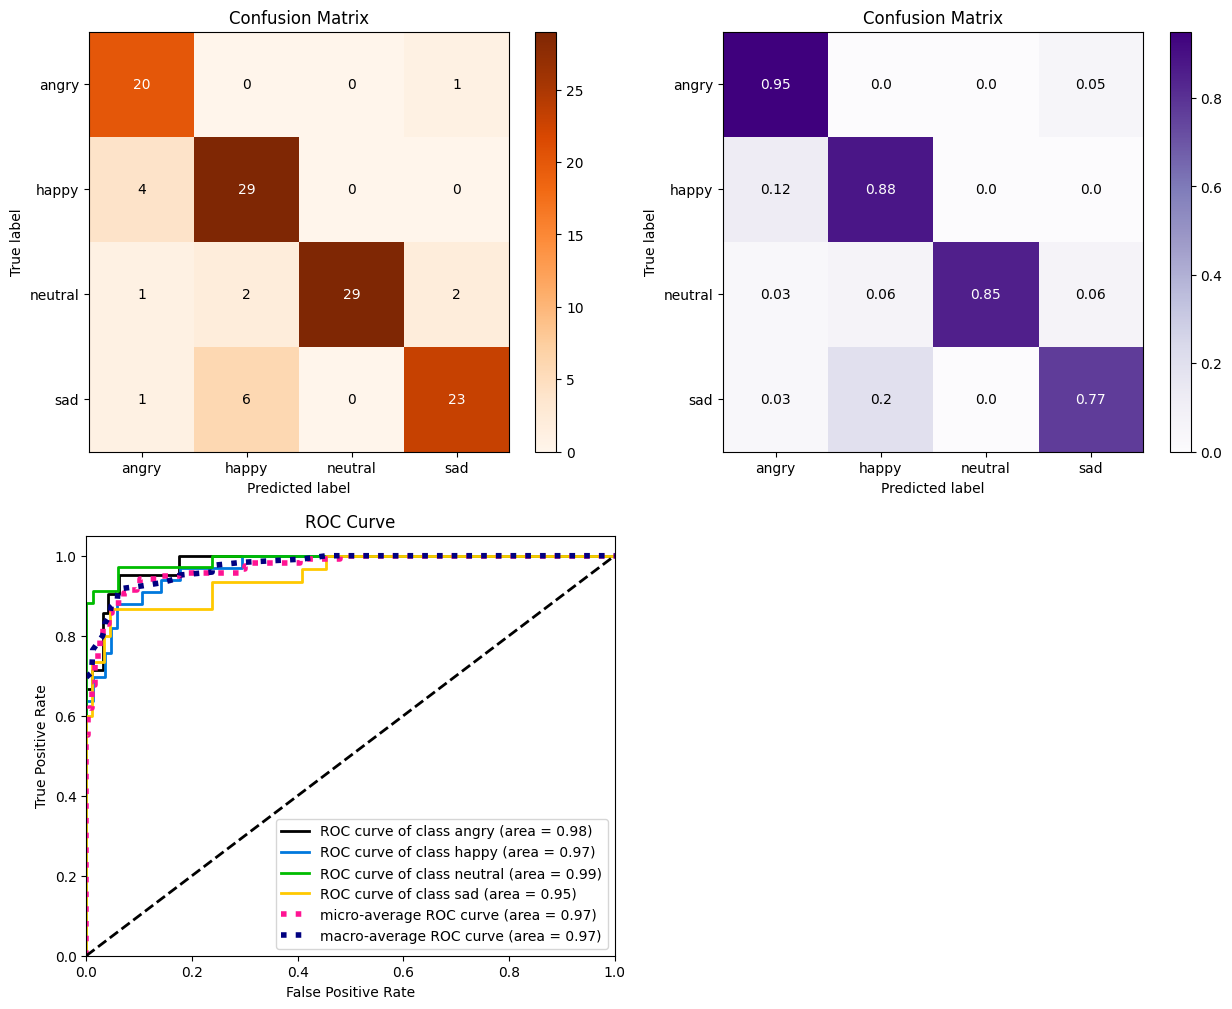

In [36]:
pred_val_y_probs = model_gbdt.predict_proba(val_X_features)
plot_visualisations(val_y, pred_val_y, pred_val_y_probs)